# Enhancing Low-Light Image Classification with CNN Architectures
#### Author: Yuesong Huang† , Wentao Jiang†
#### Date: Dec.18, 2023



#### ___Note___: Before running the code, please make sure that you have installed the required packages and downloaded the dataset and annotations. 

The instructions are as follows:

- Install the environment under the project directory with `pip install -r requirements.txt`
- Download the ExDark Dataset and Groundtruth from the link below and put them under `./data/` directory.
  - [Exclusively Dark (ExDark) Image Dataset (Official Site)](https://github.com/cs-chan/Exclusively-Dark-Image-Dataset/tree/master?tab=readme-ov-file#exclusively-dark-exdark-image-dataset-official-site)
  - [ExDark Dataset](https://github.com/cs-chan/Exclusively-Dark-Image-Dataset/tree/master/Dataset) / Official Dataset Download Link: [Google Drive (1.5Gb)](https://drive.google.com/file/d/1BHmPgu8EsHoFDDkMGLVoXIlCth2dW6Yx/view?usp=sharing)
  - [ExDark Groundtruth](https://github.com/cs-chan/Exclusively-Dark-Image-Dataset/tree/master/Groundtruth) / Official Groundtruth Download Link: [Google Drive (4.2Mb)](https://drive.google.com/file/d/1P3iO3UYn7KoBi5jiUkogJq96N6maZS1i/view?usp=sharing)

In [ ]:
import os
import gc
import math
from tqdm import tqdm
import numpy as np
import pandas as pd

from PIL import Image
import cv2
from skimage import io, exposure, filters, color
from skimage.restoration import denoise_nl_means, estimate_sigma

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, Subset, WeightedRandomSampler

import torchvision
import torchvision.transforms as transforms
import torchvision.models as models
from torchvision.models import resnet50, ResNet50_Weights, vgg19, VGG19_Weights
from torchvision.datasets import ImageFolder

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

import matplotlib.pyplot as plt
import seaborn as sns

from data.ExDark_annotator import *
from preprocessing.ExDark_imgEnhancer import *


# 1. Image Preprocessing: 
Generate "merged image annotations" and perform statistical analysis

In [ ]:
def save_or_load(file_path, creation_func):
    if not os.path.isfile(file_path):
        print(f"Annotations not found, creating new annotations at {file_path} ...")
        data = creation_func()
        data.to_csv(file_path, index=False)
    else:
        data = pd.read_csv(file_path)
    return data

annotations_file = './data/image_annotations.csv'
merged_annotations_file = './data/image_annotations_merged.csv'
data_folder = "./data/ExDark"

# Load annotations
annotations = save_or_load(annotations_file, annot_to_csv)

num_classes = annotations['class'].nunique()
classes_index = ImageFolder(data_folder).class_to_idx


Annotations not found, creating new annotations at ./data/image_annotations.csv ...
Notice from Annotator: No columns to parse from file: ./data/ExDark_Annno/Motorbike/2015_05894.jpg.txt


In [ ]:
# average_rgb(annotations)
"""
Mean Red: 40.12924235329201
STD Red: 52.62728715099054
Mean Green: 32.124028476433764
STD Green: 44.79757920593172
Mean Blue: 25.947158689970085
STD Blue: 41.229736063842445

Mean Red Norm: 0.15736957785604708
STD Red Norm: 0.20638151823917858
Mean Green Norm: 0.12597658226052458
STD Green Norm: 0.17567678119973223
Mean Blue Norm: 0.10175356349007876
STD Blue Norm: 0.1616852394660488
"""

# merged annotations exist
annotations = pd.read_csv(annotations_file)

annotations = save_or_load(
    merged_annotations_file, 
    lambda: merge_annot(annotations, classes_index)
    )

annotations.head()

Annotations not found, creating new annotations at ./data/image_annotations_merged.csv ...


,image,class,class_index,label,fpath
0,2015_00001.png,[Bicycle],[0],0,./data/ExDark/Bicycle
1,2015_00002.png,"[Bicycle, Car]","[0, 4]",0,./data/ExDark/Bicycle
2,2015_00003.png,"[Bicycle, Bus, Chair]","[0, 3, 6]",0,./data/ExDark/Bicycle
3,2015_00004.jpg,[Bicycle],[0],0,./data/ExDark/Bicycle
4,2015_00005.jpg,[Bicycle],[0],0,./data/ExDark/Bicycle


In [ ]:
def average_size(annotations):
    total_width, total_height, count = 0, 0, 0

    for _, row in annotations.iterrows():
        # with Image.open(row['fpath'] + '/' + row['image']) as img:
        with Image.open(os.path.join(row['fpath'], row['image'])) as img:
            width, height = img.size
            total_width += width
            total_height += height
            count += 1

    average_width = total_width / count
    average_height = total_height / count

    return average_width, average_height

# average annotation sizes
(819.2663678348275, 649.3580548763923)


(819.2663678348275, 649.3580548763923)

## 1.1 Image Augumentation and Transformation

In [ ]:
def get_transforms(tf, resize, target_size, mean_rgb, std_rgb):
    return {
    'train': transforms.Compose([
        transforms.Resize(resize),
        transforms.RandomResizedCrop(
            target_size,
            scale=(0.8, 1.0),
            ratio=(0.75, 1.33)
        ),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        tf,
        transforms.Normalize(mean_rgb, std_rgb)
    ]),

    'test': transforms.Compose([
        transforms.Resize(target_size),
        transforms.CenterCrop(target_size),
        transforms.ToTensor(),
        tf,
        transforms.Normalize(mean_rgb, std_rgb)
    ])
}


### 1.1.1 Visualization
We have chosen CLAHE (Contrast Limited Adaptive Histogram Equalization) as a showcase due to its performance in enhancing the visibility of features in images. 

For a comprehensive comparison and visualization, please explore [Visualization Demo notebook](./preprocessing/visualization_demo.ipynb) and [`Image preprocessing`](./preprocessing/) directory for more detail.

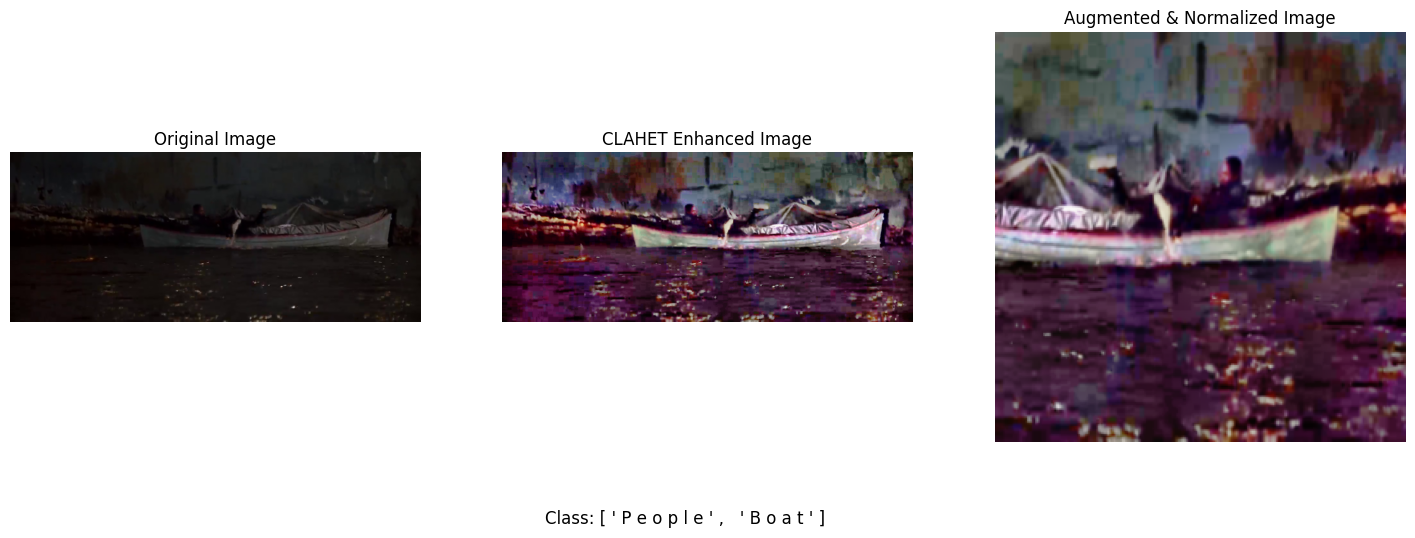

In [ ]:
# Contrast Limited Adaptive Histogram Equalization (CLAHE)
class CLAHETransform(object):
    def __call__(self, img_tensor):
        return self.clahe(img_tensor)

    def clahe(self, img_tensor):
        image = img_tensor.numpy()
        img_clahe = exposure.equalize_adapthist(image, clip_limit=0.03)
        clahe_tensor = torch.from_numpy(img_clahe)
        return clahe_tensor

sample_annotation = annotations.sample(1)
sample_image = img_read(
    os.path.join(
        sample_annotation['fpath'].iloc[0], 
        sample_annotation['image'].iloc[0]
        )
    )
img_show(
    sample_image, 
    img_enhance(CLAHETransform(), sample_image), 
    'CLAHET', 
    sample_annotation['class'].iloc[0]
    )

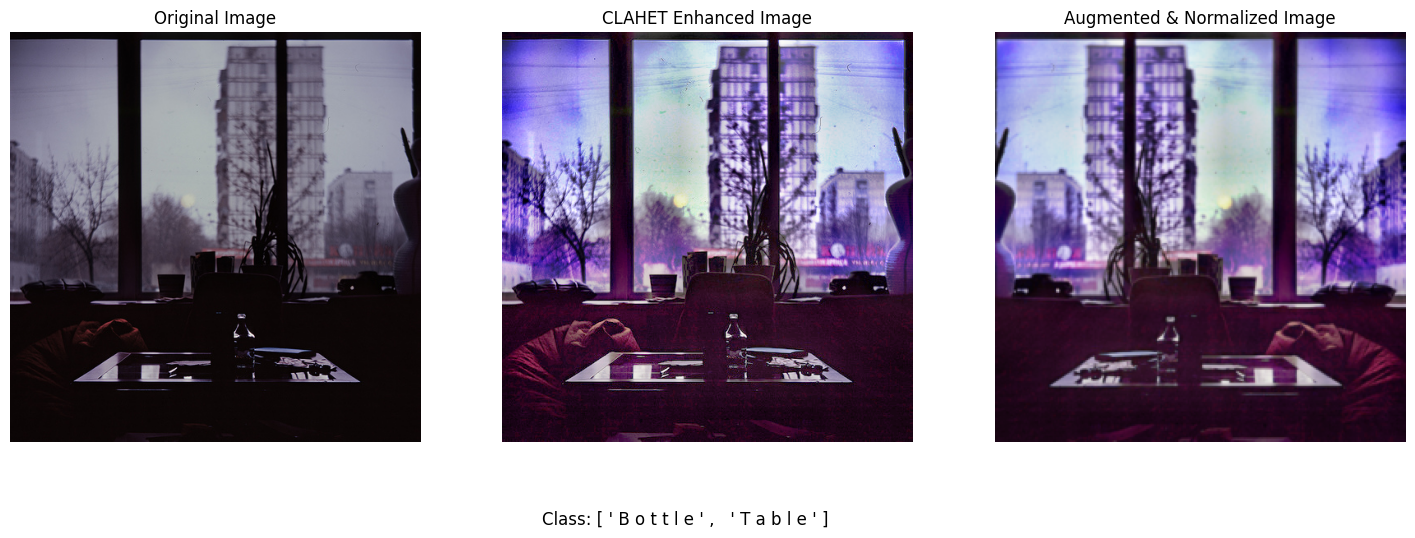

In [ ]:
# Another Example using CLAHE
sample_annotation = annotations.sample(1)
sample_image = img_read(
    os.path.join(
        sample_annotation['fpath'].iloc[0], 
        sample_annotation['image'].iloc[0]
        )
    )
img_show(sample_image, 
         img_enhance(CLAHETransform(), sample_image), 
         'CLAHET', 
         sample_annotation['class'].iloc[0]
        )

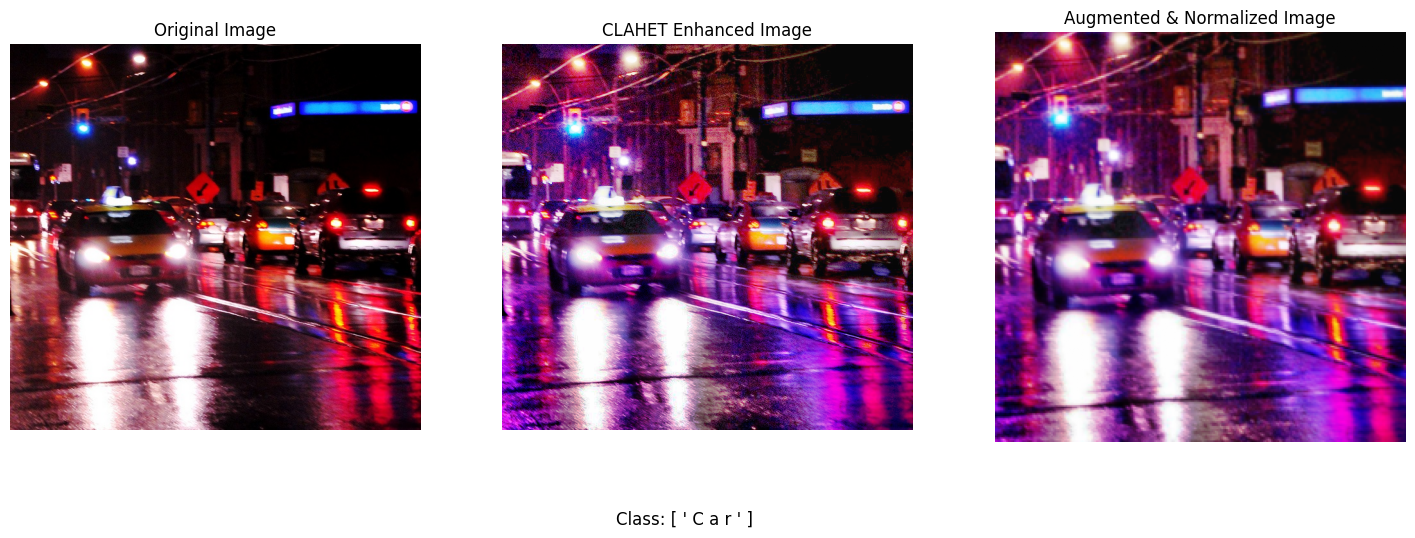

In [ ]:
sample_annotation = annotations.sample(1)
sample_image = img_read(
    os.path.join(
        sample_annotation['fpath'].iloc[0], 
        sample_annotation['image'].iloc[0]
        )
    )
img_show(sample_image, 
         img_enhance(CLAHETransform(), sample_image), 
         'CLAHET', 
         sample_annotation['class'].iloc[0]
        )

# 2. Model Building: Binary & Ternary
- 2.1 Binary Classification
  - 2.1.1 With BCELoss
  - 2.1.2 With CrossEntropyLoss

- 2.2 Ternary Classification (entered only If Classified as Creature)
  - Use BCELoss

In [ ]:
class BaseCNN(nn.Module):
    def __init__(self, num_classes=12):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=64, kernel_size=3, padding=1)
        self.relu1 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv2 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1)
        self.relu2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv3 = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1)
        self.relu3 = nn.ReLU()
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.fc1 = nn.Linear(256 * 32 * 32, 512)
        self.fc2 = nn.Linear(512, num_classes)

    def forward(self, x):
        x = self.pool1(self.relu1(self.conv1(x)))
        x = self.pool2(self.relu2(self.conv2(x)))
        x = self.pool3(self.relu3(self.conv3(x)))
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)

        return x

def model_init(num_classes):
    cnn_model = BaseCNN(num_classes)

    resnet50_model = resnet50(weights=ResNet50_Weights.DEFAULT)
    num_features = resnet50_model.fc.in_features
    resnet50_model.fc = nn.Linear(num_features, num_classes)

    vgg19_model = vgg19(weights=VGG19_Weights.DEFAULT)
    num_features = vgg19_model.classifier[6].in_features
    vgg19_model.classifier[6] = nn.Linear(num_features, num_classes)

    cnn = cnn_model.cuda()
    resnet = resnet50_model.cuda()
    vgg = vgg19_model.cuda()

    return cnn, resnet, vgg


In [ ]:
# Training Loop
def train_model(model, dataloader, criterion, optimizer, binary=False, num_epochs=20):
    for epoch in range(num_epochs):
        model.train()  # Set the model to training mode
        running_loss = 0.0

        for images, labels in dataloader:
            images, labels = images.cuda(), labels.cuda()

            # Forward pass
            outputs = model(images)

            if binary:
                loss = criterion(outputs, labels.squeeze())
            else:
                loss = criterion(outputs, labels)

            # Backward and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        # Print statistics
        epoch_loss = running_loss / len(dataloader)
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}')

def eva_model(model, dataloader, binary=False):
    model.eval()

    all_preds = []
    all_labels = []

    with torch.no_grad():
        for images, labels in dataloader:
            images, labels = images.cuda(), labels.cuda()
            outputs = model(images)
            if binary:
                preds = torch.sigmoid(outputs).round()
            else:
                _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    return all_preds, all_labels

def show_confusion_matrix(all_labels, all_preds, labels):
    cm = confusion_matrix(all_labels, all_preds)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()

def show_confusion_matrix_labels(all_labels, all_preds, labels, num_classes=12):
    num_columns = num_classes // 2 + num_classes % 2
    _, axes = plt.subplots(nrows=2, ncols=num_columns, figsize=(num_columns * 5, 2 * 4))

    all_labels_reshaped = [batch.reshape(-1, num_classes) for batch in all_labels]
    all_labels_concatenated = np.concatenate(all_labels_reshaped, axis=0)
    all_preds_reshaped = [batch.reshape(-1, num_classes) for batch in all_preds]
    all_preds_concatenated = np.concatenate(all_preds_reshaped, axis=0)

    for i in range(num_classes):
        row = i // num_columns
        col = i % num_columns
        ax = axes[row, col]

        cm = confusion_matrix(all_labels_concatenated[:, i], all_preds_concatenated[:, i])
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax)
        ax.set_xlabel(f'Class: {labels[i]}')
        ax.set_ylabel('True')
        ax.set_title('Confusion Matrix')
        ax.xaxis.set_ticklabels(['Not Present', 'Present'])
        ax.yaxis.set_ticklabels(['Not Present', 'Present'])

    plt.tight_layout()
    plt.show()


## 2.1. Binary classification: Creature vs. Auto

For First Step, we only classify 1. Creature and 2. Auto
1. Creature:
   - People
   - Cat
   - Dog

2. Auto
   - Bus
   - Bicycle
   - Motorbike

This process played a crucial role in training models to distinguish between these broad categories.

In [ ]:
# Filter for binary classification
binary_classes = [
    classes_index['People'], 
    classes_index['Cat'], 
    classes_index['Dog'], 
    classes_index['Car'], 
    classes_index['Bus'], 
    classes_index['Bicycle'], 
    classes_index['Motorbike']
    ]

binary_annotations = annotations[annotations['label'] \
                                 .isin(binary_classes)] \
                                 .copy()

# What we are doing here is to map the orig. classification into only two classes
binary_annotations['binary_label'] = binary_annotations['label'] \
                                    .map({10: 0, 5: 0, 8: 0, 0: 1, 3: 1, 4: 1, 9: 1})


In [ ]:
resize = 512
target_size = 256
mean_rgb = [0.15736957785604708, 0.12597658226052458, 0.10175356349007876]
std_rgb = [0.20638151823917858, 0.17567678119973223, 0.1616852394660488]

# Use CLAHE here for the best transform performance.
image_transforms = get_transforms(
    CLAHETransform(), 
    resize, 
    target_size, 
    mean_rgb, 
    std_rgb
    )

# average_rgb(ternary_annotations), average_size(ternary_annotations)
(837.14608371322, 647.847492747617)


(837.14608371322, 647.847492747617)

##### Customized Dataset image-label pair w/ TTS

In [ ]:
# Split the data
train_df, test_df = train_test_split(binary_annotations, test_size=0.2, stratify=binary_annotations['binary_label'])

# Custom Dataset Class
class CustomDatasetBinary(Dataset):
    def __init__(self, df, transform=None, label_type=torch.long):
        self.annotations = df
        self.label_type = label_type
        self.transform = transform

    def __len__(self):
        return len(self.annotations)

    def __getitem__(self, idx):
        img_path = os.path.join(
            self.annotations.iloc[idx, 4], 
            self.annotations.iloc[idx, 0]
            )
        image = img_read(img_path)
        label = torch.tensor([self.annotations.iloc[idx, 5]], dtype=self.label_type)

        if self.transform:
            image = self.transform(Image.fromarray(image))

        return image, label


### 2.1.1 With `criterion = nn.BCEWithLogitsLoss()`

In [ ]:
# DataLoaders for BCE
train_dataset = CustomDatasetBinary(
    train_df, 
    transform=image_transforms['train'], 
    label_type=torch.float32
    )

test_dataset = CustomDatasetBinary(
    test_df, 
    transform=image_transforms['test'], 
    label_type=torch.float32
    )

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=4)


In [ ]:
# Clearing gradients
torch.cuda.empty_cache()
gc.collect()

# Initialize models
model_cnn, model_resnet, model_vgg = model_init(1)

# Loss Function
criterion = nn.BCEWithLogitsLoss()

# Optimizer (example for ResNet50, similar for others)
optimizer_cnn = torch.optim.Adam(model_cnn.parameters(), lr=1e-5)
optimizer_resnet = torch.optim.Adam(model_resnet.parameters(), lr=1e-5)
optimizer_vgg = torch.optim.Adam(model_vgg.parameters(), lr=1e-5)


Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 188MB/s]
Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/hub/checkpoints/vgg19-dcbb9e9d.pth
100%|██████████| 548M/548M [00:03<00:00, 186MB/s]


Epoch [1/20], Loss: 0.6416
Epoch [2/20], Loss: 0.5990
Epoch [3/20], Loss: 0.5688
Epoch [4/20], Loss: 0.5525
Epoch [5/20], Loss: 0.5400
Epoch [6/20], Loss: 0.5297
Epoch [7/20], Loss: 0.5176
Epoch [8/20], Loss: 0.5109
Epoch [9/20], Loss: 0.4984
Epoch [10/20], Loss: 0.4971
Epoch [11/20], Loss: 0.4918
Epoch [12/20], Loss: 0.4755
Epoch [13/20], Loss: 0.4757
Epoch [14/20], Loss: 0.4683
Epoch [15/20], Loss: 0.4587
Epoch [16/20], Loss: 0.4543
Epoch [17/20], Loss: 0.4506
Epoch [18/20], Loss: 0.4432
Epoch [19/20], Loss: 0.4464
Epoch [20/20], Loss: 0.4318


#### 2.1.1.1 3-layer Baseline CNN for Binary Classification

In [ ]:
# Note: no transforms needed as already performed above.

# Train the baseline CNN models
train_model(model_cnn, train_loader, criterion, optimizer_cnn, num_epochs=20)

all_preds, all_labels = eva_model(model_cnn, test_loader, binary=True)
torch.save(model_cnn, 'model_cnn2_BCE.pth')
accuracy = accuracy_score(all_labels, all_preds)

print(classification_report(all_labels, all_preds, target_names=['Creature', 'Auto']))
print(f'Accuracy: %{accuracy * 100:.4f}')


              precision    recall  f1-score   support

    Creature       0.76      0.65      0.70       513
        Auto       0.66      0.76      0.71       453

    accuracy                           0.70       966
   macro avg       0.71      0.71      0.70       966
weighted avg       0.71      0.70      0.70       966

Accuracy: %70.2899


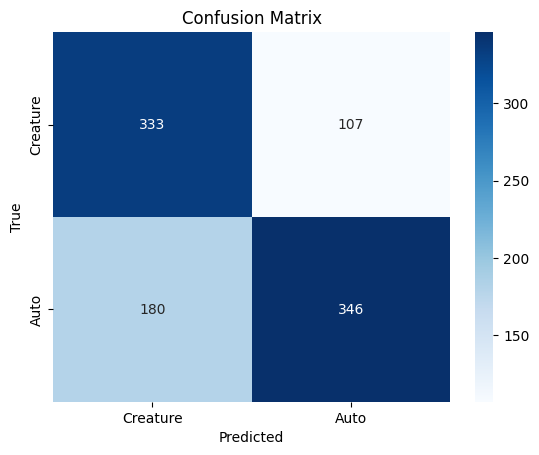

In [ ]:
show_confusion_matrix(all_preds, all_labels, ['Creature', 'Auto'])


In [ ]:
# Clearing gradients
torch.cuda.empty_cache()
gc.collect()

#### 2.1.1.2 ResNet50 backbone for Binary Classification

In [ ]:
# Use ImageNet parameter with more generalization for ResNet and VGG
resize = 512
target_size = 256
mean_rgb = [0.485, 0.456, 0.406]
std_rgb = [0.229, 0.224, 0.225]

image_transforms = get_transforms(CLAHETransform(), resize, target_size, mean_rgb, std_rgb)


In [ ]:
criterion = nn.BCEWithLogitsLoss()
train_model(model_resnet, train_loader, criterion, optimizer_resnet, num_epochs=20)


Epoch [1/20], Loss: 0.6184
Epoch [2/20], Loss: 0.3758
Epoch [3/20], Loss: 0.2174
Epoch [4/20], Loss: 0.1707
Epoch [5/20], Loss: 0.1306
Epoch [6/20], Loss: 0.1097
Epoch [7/20], Loss: 0.0906
Epoch [8/20], Loss: 0.0705
Epoch [9/20], Loss: 0.0655
Epoch [10/20], Loss: 0.0597
Epoch [11/20], Loss: 0.0513
Epoch [12/20], Loss: 0.0421
Epoch [13/20], Loss: 0.0390
Epoch [14/20], Loss: 0.0338
Epoch [15/20], Loss: 0.0293
Epoch [16/20], Loss: 0.0241
Epoch [17/20], Loss: 0.0216
Epoch [18/20], Loss: 0.0243
Epoch [19/20], Loss: 0.0193
Epoch [20/20], Loss: 0.0179


In [ ]:
all_preds, all_labels = eva_model(model_resnet, test_loader, binary=True)
torch.save(model_resnet, 'model_resnet2_BCE.pth')
accuracy = accuracy_score(all_labels, all_preds)

print(classification_report(all_labels, all_preds, target_names=['Creature', 'Auto']))
print(f'Accuracy: %{accuracy * 100:.4f}')


              precision    recall  f1-score   support

    Creature       0.95      0.93      0.94       513
        Auto       0.92      0.94      0.93       453

    accuracy                           0.94       966
   macro avg       0.94      0.94      0.94       966
weighted avg       0.94      0.94      0.94       966

Accuracy: %93.5818


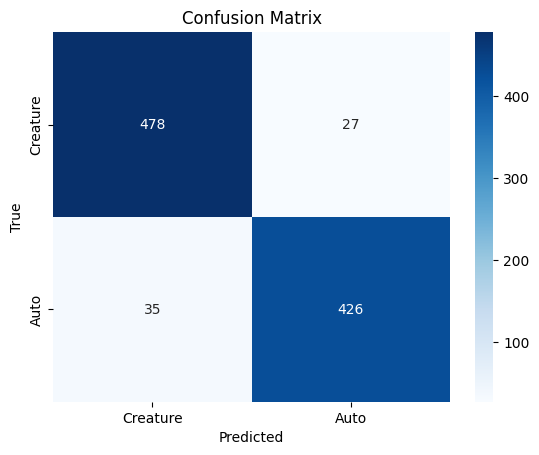

In [ ]:
show_confusion_matrix(all_preds, all_labels, ['Creature', 'Auto'])


In [ ]:
# Clearing gradients
torch.cuda.empty_cache()
gc.collect()

#### 2.1.1.3 VGG19 backbone for Binary Classification

In [ ]:
criterion = nn.BCEWithLogitsLoss()
train_model(model_vgg, train_loader, criterion, optimizer_vgg, num_epochs=20)


Epoch [1/20], Loss: 0.3290
Epoch [2/20], Loss: 0.1831
Epoch [3/20], Loss: 0.1305
Epoch [4/20], Loss: 0.0970
Epoch [5/20], Loss: 0.0802
Epoch [6/20], Loss: 0.0562
Epoch [7/20], Loss: 0.0372
Epoch [8/20], Loss: 0.0316
Epoch [9/20], Loss: 0.0236
Epoch [10/20], Loss: 0.0309
Epoch [11/20], Loss: 0.0132
Epoch [12/20], Loss: 0.0123
Epoch [13/20], Loss: 0.0212
Epoch [14/20], Loss: 0.0056
Epoch [15/20], Loss: 0.0036
Epoch [16/20], Loss: 0.0063
Epoch [17/20], Loss: 0.0061
Epoch [18/20], Loss: 0.0097
Epoch [19/20], Loss: 0.0155
Epoch [20/20], Loss: 0.0074


In [ ]:
all_preds, all_labels = eva_model(model_vgg, test_loader, binary=True)
torch.save(model_vgg, 'model_vgg2_BCE.pth')
accuracy = accuracy_score(all_labels, all_preds)

print(classification_report(all_labels, all_preds, target_names=['Creature', 'Auto']))
print(f'Accuracy: %{accuracy * 100:.4f}')


              precision    recall  f1-score   support

    Creature       0.91      0.94      0.92       513
        Auto       0.93      0.89      0.91       453

    accuracy                           0.92       966
   macro avg       0.92      0.91      0.92       966
weighted avg       0.92      0.92      0.92       966

Accuracy: %91.6149


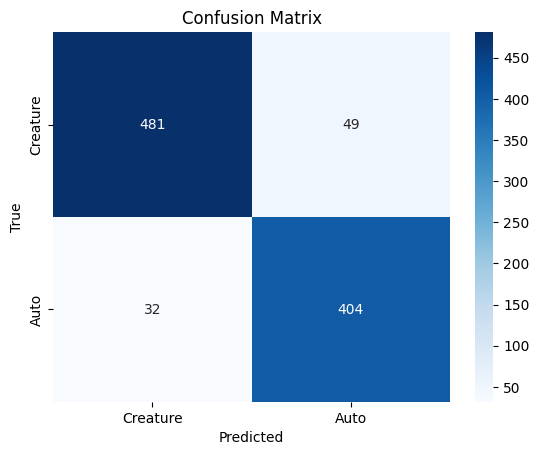

In [ ]:
show_confusion_matrix(all_preds, all_labels, ['Creature', 'Auto'])


In [ ]:
# Clearing gradients
torch.cuda.empty_cache()
gc.collect()

### 2.1.2 With `criterion = nn.CrossEntropyLoss()`
Just for more Exploration

- ResNet50
- VGG19

In [ ]:
# Data Loaders for CrossEntropy
train_dataset = CustomDatasetBinary(train_df, transform=image_transforms['train'])
test_dataset = CustomDatasetBinary(test_df, transform=image_transforms['test'])

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=4)


In [ ]:
# Initialize models
_, model_resnet, model_vgg = model_init(2)

# Loss Function
criterion = nn.CrossEntropyLoss()

optimizer_resnet = torch.optim.Adam(model_resnet.parameters(), lr=1e-5)
optimizer_vgg = torch.optim.Adam(model_vgg.parameters(), lr=1e-5)

#### 2.1.2.1 ResNet50 backbone for Binary Classification

In [ ]:
# Train the models
train_model(model_resnet, train_loader, criterion, optimizer_resnet, binary=True, num_epochs=20)


Epoch [1/20], Loss: 0.5910
Epoch [2/20], Loss: 0.3448
Epoch [3/20], Loss: 0.2158
Epoch [4/20], Loss: 0.1640
Epoch [5/20], Loss: 0.1272
Epoch [6/20], Loss: 0.1043
Epoch [7/20], Loss: 0.0897
Epoch [8/20], Loss: 0.0752
Epoch [9/20], Loss: 0.0608
Epoch [10/20], Loss: 0.0514
Epoch [11/20], Loss: 0.0452
Epoch [12/20], Loss: 0.0376
Epoch [13/20], Loss: 0.0327
Epoch [14/20], Loss: 0.0331
Epoch [15/20], Loss: 0.0267
Epoch [16/20], Loss: 0.0256
Epoch [17/20], Loss: 0.0204
Epoch [18/20], Loss: 0.0208
Epoch [19/20], Loss: 0.0179
Epoch [20/20], Loss: 0.0150


In [ ]:
all_preds, all_labels = eva_model(model_resnet, test_loader)
torch.save(model_resnet, 'model_resnet2.pth')
accuracy = accuracy_score(all_labels, all_preds)

print(classification_report(all_labels, all_preds, target_names=['Creature', 'Auto']))
print(f'Accuracy: %{accuracy * 100:.4f}')


              precision    recall  f1-score   support

    Creature       0.95      0.93      0.94       513
        Auto       0.92      0.94      0.93       453

    accuracy                           0.94       966
   macro avg       0.94      0.94      0.94       966
weighted avg       0.94      0.94      0.94       966

Accuracy: %93.5818


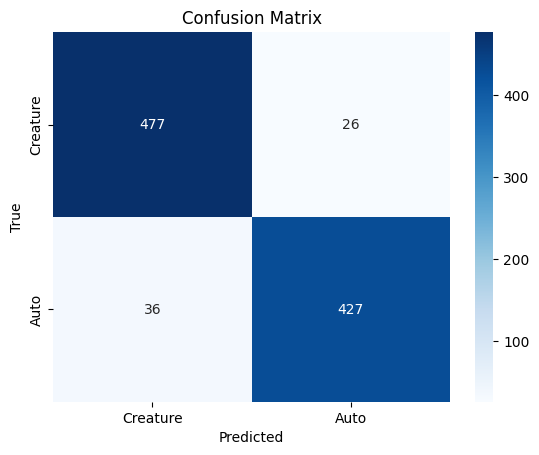

In [ ]:
show_confusion_matrix(all_preds, all_labels, ['Creature', 'Auto'])


In [ ]:
# Clearing gradients
torch.cuda.empty_cache()
gc.collect()

#### 2.1.2.2 VGG19 for Binary Classification

In [ ]:
criterion = nn.CrossEntropyLoss()
train_model(model_vgg, train_loader, criterion, optimizer_vgg, binary=True, num_epochs=20)


Epoch [1/20], Loss: 0.3129
Epoch [2/20], Loss: 0.1806
Epoch [3/20], Loss: 0.1270
Epoch [4/20], Loss: 0.1014
Epoch [5/20], Loss: 0.0709
Epoch [6/20], Loss: 0.0525
Epoch [7/20], Loss: 0.0349
Epoch [8/20], Loss: 0.0274
Epoch [9/20], Loss: 0.0202
Epoch [10/20], Loss: 0.0204
Epoch [11/20], Loss: 0.0154
Epoch [12/20], Loss: 0.0129
Epoch [13/20], Loss: 0.0167
Epoch [14/20], Loss: 0.0186
Epoch [15/20], Loss: 0.0125
Epoch [16/20], Loss: 0.0088
Epoch [17/20], Loss: 0.0064
Epoch [18/20], Loss: 0.0070
Epoch [19/20], Loss: 0.0049
Epoch [20/20], Loss: 0.0064


In [ ]:
all_preds, all_labels = eva_model(model_vgg, test_loader)
torch.save(model_vgg, 'model_vgg2.pth')
accuracy = accuracy_score(all_labels, all_preds)

print(classification_report(all_labels, all_preds, target_names=['Creature', 'Auto']))
print(f'Accuracy: %{accuracy * 100:.4f}')


              precision    recall  f1-score   support

    Creature       0.95      0.92      0.93       513
        Auto       0.91      0.94      0.93       453

    accuracy                           0.93       966
   macro avg       0.93      0.93      0.93       966
weighted avg       0.93      0.93      0.93       966

Accuracy: %93.0642


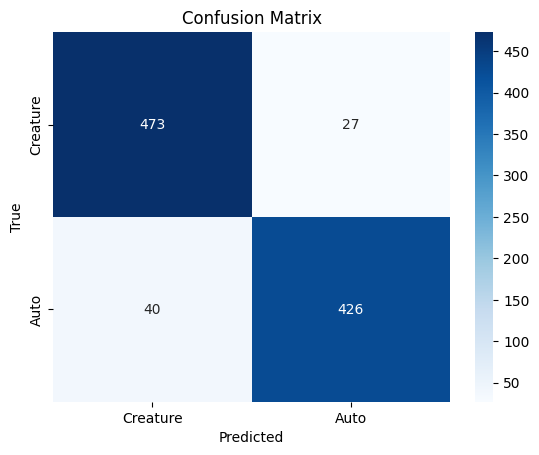

In [ ]:
show_confusion_matrix(all_preds, all_labels, ['Creature', 'Auto'])


In [ ]:
# Clearing gradients
torch.cuda.empty_cache()
gc.collect()

## 2.2 Ternary classification: People vs. Cat vs. Dog
Note: enter only **If** Classified as `Creature` <br>
With `criterion = CrossEntropyLoss()`

In [ ]:
# Filter for ternary classification
ternary_classes = [classes_index['People'], classes_index['Cat'], classes_index['Dog']]

ternary_annotations = annotations[annotations['label'] \
                                  .isin(ternary_classes)] \
                                  .copy()

ternary_annotations['ternary_label'] = ternary_annotations['label'] \
                                                            .map({10: 0, 5: 1, 8: 2})


In [ ]:
# Custom RGB param calculated in Helper "Annotation" module

resize = 512
target_size = 256
mean_rgb = [0.15736957785604708, 0.12597658226052458, 0.10175356349007876]
std_rgb = [0.20638151823917858, 0.17567678119973223, 0.1616852394660488]

image_transforms = get_transforms(
    CLAHETransform(), 
    resize, 
    target_size, 
    mean_rgb, 
    std_rgb
    )

# average_rgb(ternary_annotations), average_size(ternary_annotations)
(779.4888802184939, 611.9192352711666)


(779.4888802184939, 611.9192352711666)

In [ ]:
def ter_sampler(train_df):
    ''' Calculate weights for each class '''
    class_counts = [
        train_df[train_df['ternary_label'] == 0].shape[0], 
        train_df[train_df['ternary_label'] == 1].shape[0], 
        train_df[train_df['ternary_label'] == 2].shape[0]
        ]
    
    num_samples = sum(class_counts)
    
    class_weights = [num_samples/class_counts[i] for i in range(len(class_counts))]
    sample_weights = [class_weights[ternary_label] for ternary_label in train_df['ternary_label']]

    return WeightedRandomSampler(sample_weights, num_samples, replacement=True)


In [ ]:
# Split the data
train_df, test_df = train_test_split(ternary_annotations, test_size=0.2, stratify=ternary_annotations['ternary_label'])

# Custom Dataset Class
class CustomDatasetTernary(Dataset):
    def __init__(self, df, transform=None):
        self.annotations = df
        self.transform = transform

    def __len__(self):
        return len(self.annotations)

    def __getitem__(self, idx):
        img_path = os.path.join(self.annotations.iloc[idx, 4], self.annotations.iloc[idx, 0])
        image = img_read(img_path)
        label = torch.tensor(self.annotations.iloc[idx, 5], dtype=torch.long)

        if self.transform:
            image = self.transform(Image.fromarray(image))

        return image, label

# Data Loaders
train_df.reset_index(drop=True, inplace=True)
train_dataset = CustomDatasetTernary(train_df, transform=image_transforms['train'])
test_dataset = CustomDatasetTernary(test_df, transform=image_transforms['test'])

train_loader = DataLoader(train_dataset, batch_size=32, sampler=ter_sampler(train_df), num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=4)


In [ ]:
# Initialize models
model_cnn, model_resnet, model_vgg = model_init(3)

# Loss Function
criterion = nn.CrossEntropyLoss()

# Optimizer (example for ResNet50, similar for others)
optimizer_cnn = torch.optim.Adam(model_cnn.parameters(), lr=1e-5)
optimizer_resnet = torch.optim.Adam(model_resnet.parameters(), lr=1e-5)
optimizer_vgg = torch.optim.Adam(model_vgg.parameters(), lr=1e-5)


### 2.2.1 3-layer Baseline CNN Ternary Classification

In [ ]:
# Train the models
train_model(model_cnn, train_loader, criterion, optimizer_cnn, num_epochs=20)


Epoch [1/20], Loss: 1.0994
Epoch [2/20], Loss: 1.0589
Epoch [3/20], Loss: 1.0390
Epoch [4/20], Loss: 1.0149
Epoch [5/20], Loss: 0.9994
Epoch [6/20], Loss: 1.0005
Epoch [7/20], Loss: 0.9674
Epoch [8/20], Loss: 0.9700
Epoch [9/20], Loss: 0.9461
Epoch [10/20], Loss: 0.9465
Epoch [11/20], Loss: 0.9157
Epoch [12/20], Loss: 0.8963
Epoch [13/20], Loss: 0.9049
Epoch [14/20], Loss: 0.8970
Epoch [15/20], Loss: 0.8498
Epoch [16/20], Loss: 0.8837
Epoch [17/20], Loss: 0.8440
Epoch [18/20], Loss: 0.8574
Epoch [19/20], Loss: 0.8536
Epoch [20/20], Loss: 0.8354


In [ ]:
all_preds, all_labels = eva_model(model_cnn, test_loader)
torch.save(model_cnn, 'model_cnn3.pth')
accuracy = accuracy_score(all_labels, all_preds)

print(classification_report(all_labels, all_preds, target_names=['People', 'Cat', 'Dog']))
print(f'Accuracy: %{accuracy * 100:.4f}')


              precision    recall  f1-score   support

      People       0.67      0.69      0.68       258
         Cat       0.46      0.37      0.41       134
         Dog       0.31      0.36      0.33       121

    accuracy                           0.53       513
   macro avg       0.48      0.47      0.47       513
weighted avg       0.53      0.53      0.53       513

Accuracy: %52.8265


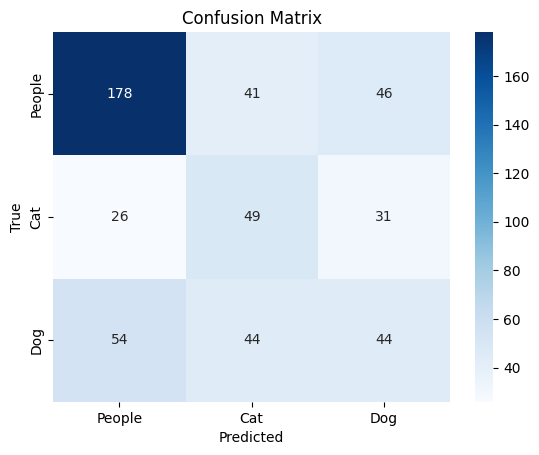

In [ ]:
show_confusion_matrix(all_preds, all_labels, ['People', 'Cat', 'Dog'])


In [ ]:
# Clearing gradients
torch.cuda.empty_cache()
gc.collect()

### 2.2.2 ResNet50 backbone for Ternary Classification

In [ ]:
# Use ImageNet std-RGB param
resize = 512
target_size = 256
mean_rgb = [0.485, 0.456, 0.406]
std_rgb = [0.229, 0.224, 0.225]
image_transforms = get_transforms(
    CLAHETransform(), 
    resize, 
    target_size, 
    mean_rgb, 
    std_rgb
    )


In [ ]:
criterion = nn.CrossEntropyLoss()
train_model(model_resnet, train_loader, criterion, optimizer_resnet, num_epochs=20)


Epoch [1/20], Loss: 1.0537
Epoch [2/20], Loss: 0.8887
Epoch [3/20], Loss: 0.6764
Epoch [4/20], Loss: 0.5044
Epoch [5/20], Loss: 0.3711
Epoch [6/20], Loss: 0.3158
Epoch [7/20], Loss: 0.2533
Epoch [8/20], Loss: 0.2112
Epoch [9/20], Loss: 0.1822
Epoch [10/20], Loss: 0.1624
Epoch [11/20], Loss: 0.1582
Epoch [12/20], Loss: 0.1205
Epoch [13/20], Loss: 0.1027
Epoch [14/20], Loss: 0.1032
Epoch [15/20], Loss: 0.0894
Epoch [16/20], Loss: 0.1087
Epoch [17/20], Loss: 0.0807
Epoch [18/20], Loss: 0.0797
Epoch [19/20], Loss: 0.0686
Epoch [20/20], Loss: 0.0560


In [ ]:
all_preds, all_labels = eva_model(model_resnet, test_loader)
torch.save(model_resnet, 'model_resnet3.pth')
accuracy = accuracy_score(all_labels, all_preds)

print(classification_report(all_labels, all_preds, target_names=['People', 'Cat', 'Dog']))
print(f'Accuracy: %{accuracy * 100:.4f}')


              precision    recall  f1-score   support

      People       0.98      0.93      0.96       258
         Cat       0.92      0.92      0.92       134
         Dog       0.82      0.92      0.87       121

    accuracy                           0.92       513
   macro avg       0.91      0.92      0.91       513
weighted avg       0.93      0.92      0.93       513

Accuracy: %92.3977


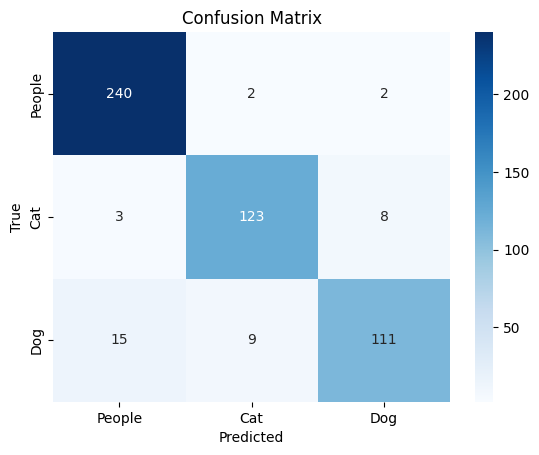

In [ ]:
show_confusion_matrix(all_preds, all_labels, ['People', 'Cat', 'Dog'])


In [ ]:
# Clearing gradients
torch.cuda.empty_cache()
gc.collect()


### 2.2.3 VGG19 backbone for Ternary Classification

In [ ]:
criterion = nn.CrossEntropyLoss()
train_model(model_vgg, train_loader, criterion, optimizer_vgg, num_epochs=20)


Epoch [1/20], Loss: 0.7866
Epoch [2/20], Loss: 0.4180
Epoch [3/20], Loss: 0.3297
Epoch [4/20], Loss: 0.2599
Epoch [5/20], Loss: 0.1804
Epoch [6/20], Loss: 0.1607
Epoch [7/20], Loss: 0.1275
Epoch [8/20], Loss: 0.0904
Epoch [9/20], Loss: 0.0565
Epoch [10/20], Loss: 0.0473
Epoch [11/20], Loss: 0.0627
Epoch [12/20], Loss: 0.0290
Epoch [13/20], Loss: 0.0226
Epoch [14/20], Loss: 0.0269
Epoch [15/20], Loss: 0.0336
Epoch [16/20], Loss: 0.0202
Epoch [17/20], Loss: 0.0156
Epoch [18/20], Loss: 0.0066
Epoch [19/20], Loss: 0.0159
Epoch [20/20], Loss: 0.0289


In [ ]:
all_preds, all_labels = eva_model(model_vgg, test_loader)
torch.save(model_vgg, 'model_vgg3.pth')
accuracy = accuracy_score(all_labels, all_preds)

print(classification_report(all_labels, all_preds, target_names=['People', 'Cat', 'Dog']))
print(f'Accuracy: %{accuracy * 100:.4f}')


              precision    recall  f1-score   support

      People       0.95      0.95      0.95       258
         Cat       0.78      0.88      0.83       134
         Dog       0.86      0.74      0.79       121

    accuracy                           0.88       513
   macro avg       0.86      0.85      0.85       513
weighted avg       0.88      0.88      0.88       513

Accuracy: %87.9142


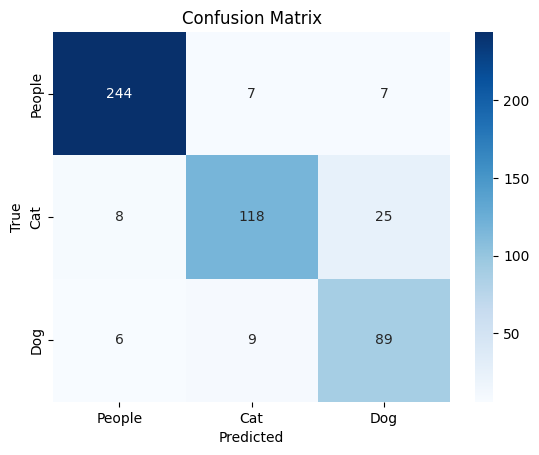

In [ ]:
show_confusion_matrix(all_preds, all_labels, ['People', 'Cat', 'Dog'])


In [ ]:
# Clearing gradients
torch.cuda.empty_cache()
gc.collect()


# 3. Model Building: Multilabel N-ary Classification: (N=12)
With `criterion = nn.BCEWithLogitsLoss()`

In [ ]:
def eva_model_labels(model, dataloader):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for images, labels in dataloader:
            images, labels = images.cuda(), labels.cuda()

            # Forward pass and record predictions
            outputs = model(images)
            probabilities = torch.sigmoid(outputs)
            predictions = probabilities > 0.5

            all_preds.extend(predictions.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    return all_preds, all_labels


In [ ]:
# Transform using customized-RGB value for ExDark Value
resize = 512
target_size = 256
mean_rgb = [0.15736957785604708, 0.12597658226052458, 0.10175356349007876]
std_rgb = [0.20638151823917858, 0.17567678119973223, 0.1616852394660488]
image_transforms = get_transforms(
    CLAHETransform(), 
    resize, 
    target_size, 
    mean_rgb, 
    std_rgb
    )


##### Customized Dataset image-label pair w/ TTS

In [ ]:
train_df, test_df = train_test_split(annotations, test_size=0.2, stratify=annotations['label'])

# Custom Dataset Class
class CustomDatasetLabels(Dataset):
    def __init__(self, df, num_classes, transform=None):
        self.annotations = df
        self.transform = transform
        self.num_classes = num_classes

    def __len__(self):
        return len(self.annotations)

    def __getitem__(self, idx):
        img_path = os.path.join(self.annotations.iloc[idx, 4], self.annotations.iloc[idx, 0])
        image = img_read(img_path)

        labels = torch.zeros(self.num_classes)
        labels[self.annotations.iloc[idx, 2]] = 1

        if self.transform:
            image = self.transform(Image.fromarray(image))

        return image, labels

# Data Loaders
train_dataset = CustomDatasetLabels(train_df, num_classes, transform=image_transforms['train'])
test_dataset = CustomDatasetLabels(test_df, num_classes, transform=image_transforms['test'])

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=4)


In [ ]:
# Initialize models
model_cnn, model_resnet, model_vgg = model_init(num_classes)

# Loss Function
criterion = nn.BCEWithLogitsLoss()

# Optimizer (example for ResNet50, similar for others)
optimizer_cnn = torch.optim.Adam(model_cnn.parameters(), lr=1e-5)
optimizer_resnet = torch.optim.Adam(model_resnet.parameters(), lr=1e-5)
optimizer_vgg = torch.optim.Adam(model_vgg.parameters(), lr=1e-5)

### 3.1 3-layer Baseline CNN Multilabel N-ary Classification

In [ ]:
train_model(model_cnn, train_loader, criterion, optimizer_cnn, num_epochs=20)


Epoch [1/20], Loss: 0.3880
Epoch [2/20], Loss: 0.3605
Epoch [3/20], Loss: 0.3499
Epoch [4/20], Loss: 0.3437
Epoch [5/20], Loss: 0.3379
Epoch [6/20], Loss: 0.3322
Epoch [7/20], Loss: 0.3287
Epoch [8/20], Loss: 0.3249
Epoch [9/20], Loss: 0.3208
Epoch [10/20], Loss: 0.3186
Epoch [11/20], Loss: 0.3144
Epoch [12/20], Loss: 0.3096
Epoch [13/20], Loss: 0.3077
Epoch [14/20], Loss: 0.3042
Epoch [15/20], Loss: 0.2998
Epoch [16/20], Loss: 0.2980
Epoch [17/20], Loss: 0.2951
Epoch [18/20], Loss: 0.2916
Epoch [19/20], Loss: 0.2879
Epoch [20/20], Loss: 0.2847


In [ ]:
all_preds, all_labels = eva_model_labels(model_cnn, test_loader)
torch.save(model_cnn, 'model_cnn12.pth')
accuracy = accuracy_score(all_labels, all_preds)

print(classification_report(all_labels, all_preds, target_names=list(classes_index.keys()), zero_division=0.0))
print(f'Accuracy: %{accuracy * 100:.4f}')


              precision    recall  f1-score   support

     Bicycle       0.42      0.09      0.15       145
        Boat       0.63      0.47      0.54       137
      Bottle       1.00      0.01      0.03       141
         Bus       0.62      0.22      0.33       113
         Car       0.48      0.22      0.30       263
         Cat       0.18      0.01      0.02       152
       Chair       0.52      0.04      0.08       250
         Cup       0.29      0.02      0.04       172
         Dog       0.34      0.14      0.20       173
   Motorbike       0.57      0.03      0.06       121
      People       0.48      0.62      0.54       525
       Table       0.75      0.07      0.13       219

   micro avg       0.49      0.23      0.31      2411
   macro avg       0.52      0.16      0.20      2411
weighted avg       0.51      0.23      0.25      2411
 samples avg       0.29      0.22      0.23      2411

Accuracy: %8.2145


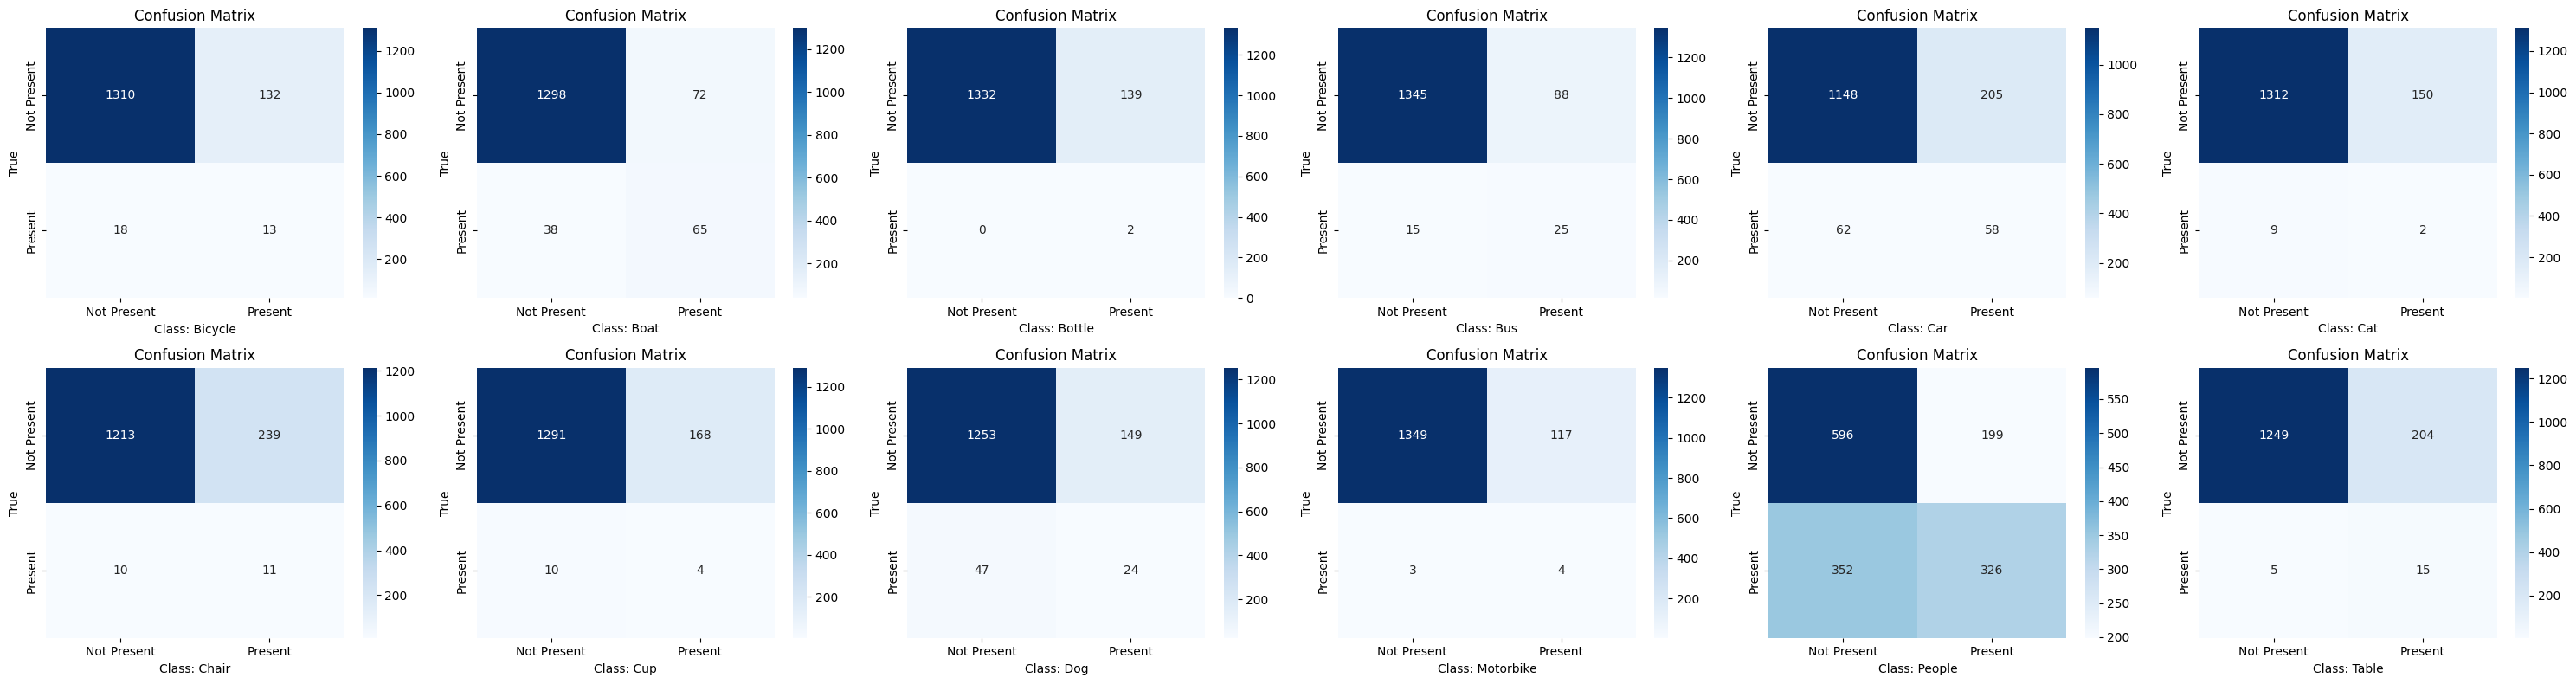

In [ ]:
show_confusion_matrix_labels(all_preds, all_labels, list(classes_index.keys()))


In [ ]:
# Clearing gradients
torch.cuda.empty_cache()
gc.collect()

### 3.2 ResNet50 Backbone Multilabel N-ary Classification

In [ ]:
resize = 512
target_size = 256
mean_rgb = [0.485, 0.456, 0.406]
std_rgb = [0.229, 0.224, 0.225]
image_transforms = get_transforms(CLAHETransform(), resize, target_size, mean_rgb, std_rgb)


In [ ]:
criterion = nn.BCEWithLogitsLoss()
train_model(model_resnet, train_loader, criterion, optimizer_resnet, num_epochs=20)


Epoch [1/20], Loss: 0.5472
Epoch [2/20], Loss: 0.3491
Epoch [3/20], Loss: 0.2571
Epoch [4/20], Loss: 0.2056
Epoch [5/20], Loss: 0.1758
Epoch [6/20], Loss: 0.1577
Epoch [7/20], Loss: 0.1441
Epoch [8/20], Loss: 0.1333
Epoch [9/20], Loss: 0.1249
Epoch [10/20], Loss: 0.1193
Epoch [11/20], Loss: 0.1110
Epoch [12/20], Loss: 0.1056
Epoch [13/20], Loss: 0.1008
Epoch [14/20], Loss: 0.0949
Epoch [15/20], Loss: 0.0912
Epoch [16/20], Loss: 0.0853
Epoch [17/20], Loss: 0.0814
Epoch [18/20], Loss: 0.0793
Epoch [19/20], Loss: 0.0753
Epoch [20/20], Loss: 0.0693


In [ ]:
all_preds, all_labels = eva_model_labels(model_resnet, test_loader)
torch.save(model_resnet, 'model_resnet12.pth')
accuracy = accuracy_score(all_labels, all_preds)


In [ ]:
print(classification_report(all_labels, all_preds, target_names=list(classes_index.keys()), zero_division=0.0))
print(f'Accuracy: %{accuracy * 100:.4f}')


              precision    recall  f1-score   support

     Bicycle       0.96      0.72      0.82       151
        Boat       0.98      0.89      0.93       139
      Bottle       0.88      0.65      0.75       152
         Bus       0.93      0.77      0.85       111
         Car       0.88      0.69      0.77       260
         Cat       0.88      0.82      0.85       152
       Chair       0.80      0.70      0.75       242
         Cup       0.86      0.74      0.80       182
         Dog       0.89      0.77      0.83       172
   Motorbike       0.92      0.71      0.80       122
      People       0.91      0.80      0.85       548
       Table       0.76      0.69      0.72       198

   micro avg       0.88      0.75      0.81      2429
   macro avg       0.89      0.75      0.81      2429
weighted avg       0.88      0.75      0.81      2429
 samples avg       0.87      0.80      0.82      2429

Accuracy: %60.1494


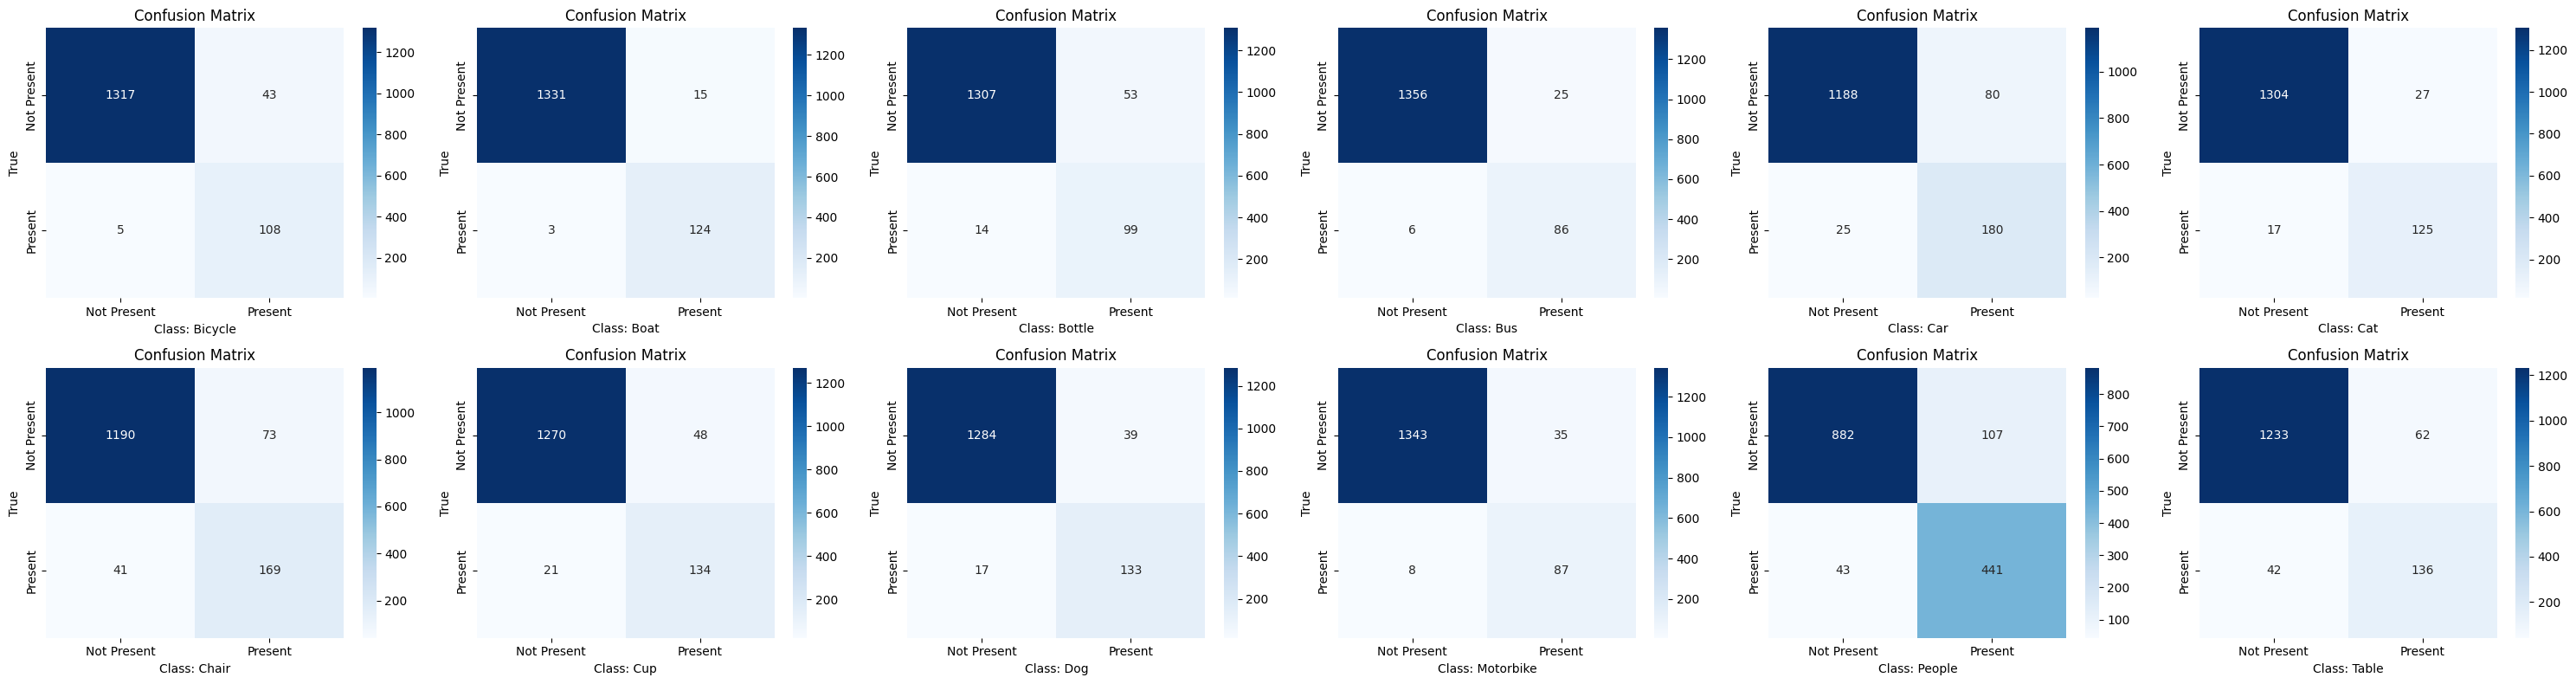

In [ ]:
show_confusion_matrix_labels(all_preds, all_labels, list(classes_index.keys()))


In [ ]:
# Clearing gradients
torch.cuda.empty_cache()
gc.collect()

### 3.3 VGG19 Backbone Multilabel N-ary Classification

In [ ]:
criterion = nn.BCEWithLogitsLoss()
train_model(model_vgg, train_loader, criterion, optimizer_vgg, num_epochs=20)


Epoch [1/20], Loss: 0.3309
Epoch [2/20], Loss: 0.2012
Epoch [3/20], Loss: 0.1665
Epoch [4/20], Loss: 0.1461
Epoch [5/20], Loss: 0.1322
Epoch [6/20], Loss: 0.1198
Epoch [7/20], Loss: 0.1079
Epoch [8/20], Loss: 0.1001
Epoch [9/20], Loss: 0.0910
Epoch [10/20], Loss: 0.0806
Epoch [11/20], Loss: 0.0716
Epoch [12/20], Loss: 0.0665
Epoch [13/20], Loss: 0.0556
Epoch [14/20], Loss: 0.0490
Epoch [15/20], Loss: 0.0454
Epoch [16/20], Loss: 0.0429
Epoch [17/20], Loss: 0.0344
Epoch [18/20], Loss: 0.0322
Epoch [19/20], Loss: 0.0293
Epoch [20/20], Loss: 0.0251


In [ ]:
all_preds, all_labels = eva_model_labels(model_vgg, test_loader)
torch.save(model_vgg, 'model_vgg12.pth')
accuracy = accuracy_score(all_labels, all_preds)


In [ ]:
print(classification_report(all_labels, all_preds, target_names=list(classes_index.keys()), zero_division=0.0))
print(f'Accuracy: %{accuracy * 100:.4f}')


              precision    recall  f1-score   support

     Bicycle       0.72      0.77      0.74       151
        Boat       0.92      0.92      0.92       139
      Bottle       0.81      0.66      0.73       152
         Bus       0.84      0.76      0.80       111
         Car       0.82      0.72      0.77       260
         Cat       0.76      0.80      0.78       152
       Chair       0.71      0.77      0.74       242
         Cup       0.79      0.59      0.68       182
         Dog       0.85      0.70      0.76       172
   Motorbike       0.81      0.79      0.80       122
      People       0.88      0.79      0.84       548
       Table       0.72      0.69      0.70       198

   micro avg       0.81      0.75      0.78      2429
   macro avg       0.80      0.75      0.77      2429
weighted avg       0.81      0.75      0.78      2429
 samples avg       0.82      0.79      0.78      2429

Accuracy: %54.8540


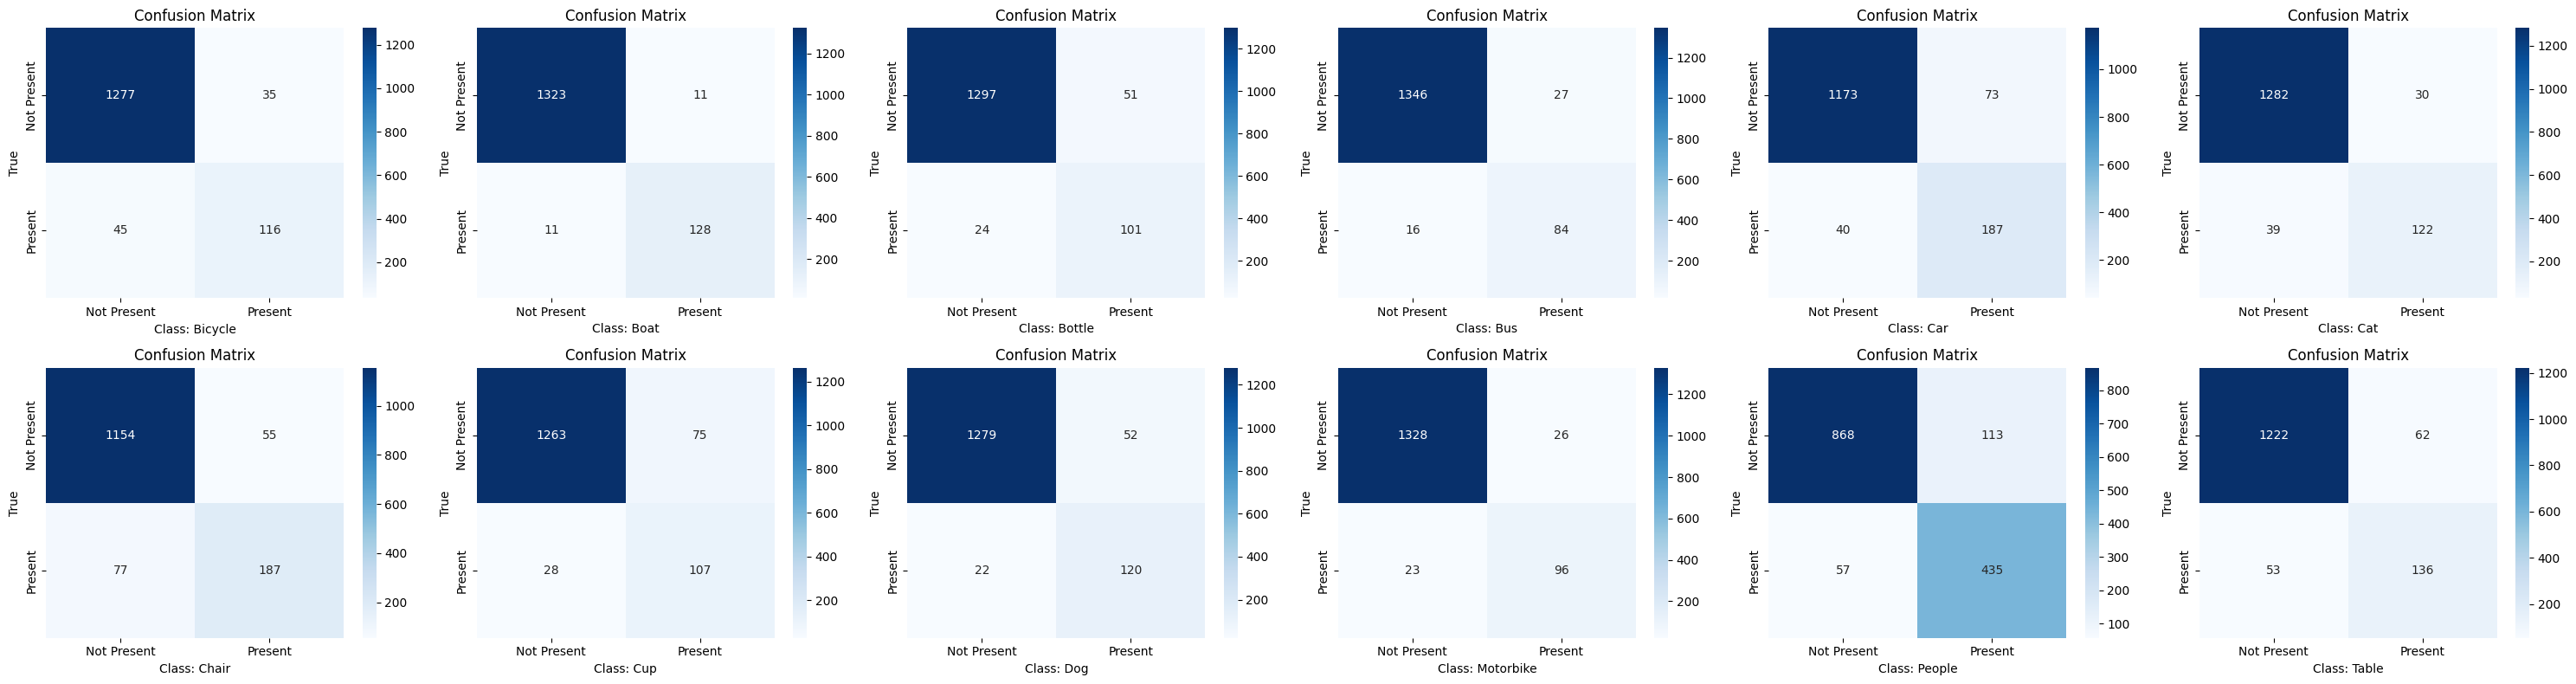

In [ ]:
show_confusion_matrix_labels(all_preds, all_labels, list(classes_index.keys()))
